# Прогнозирование спроса товаров собственного производства


### Описание задачи

Необходимо создать алгоритм прогноза спроса на 14 дней для товаров собственного производства. Гранулярность ТК-SKU-День.
 

### Описание данных

1. **sales_df_train.csv** –данные по продажам за скользящий год для обучения.

     * *st_id* – захэшированное id магазина;
     * *pr_sku_id* – захэшированное id товара;
     * *date* – дата;
     * *pr_sales_type_id* – флаг наличия промо;
     * *pr_sales_in_units* – число проданных товаров без признака промо;
     * *pr_promo_sales_in_units* – число проданных товаров с признаком промо;
     * *pr_sales_in_rub* – продажи без признака промо в РУБ;
     * *pr_promo_sales_in_rub* – продажи с признаком промо в РУБ;


2. **pr_df.csv** – данные по товарной иерархии.

    * *pr_group_id* – захэшированная группа товара;
    * *pr_cat_id* – захэшированная категория товара;
    * *pr_subcat_id* – захэшированная подкатегория товара;
    * *pr_sku_id* – захэшированное id товара;
    * *pr_uom_id* (маркер, обозначающий продаётся товар на вес или в ШТ).
    
    
    
3. **pr_st.csv** – данные по магазинам.

    * *st_id* – захэшированное id магазина;
    * *st_city_id* – захэшированное id города;
    * *st_division_code id* – захэшированное id дивизиона;
    * *st_type_format_id* – id формата магазина;
    * *st_type_loc_id* – id тип локации/окружения магазина;
    * *st_type_size_id* – id типа размера магазина;
    * *st_is_active* – флаг активного магазина на данный момент.



## Первичное ознакомление с данными

In [1]:
# Установка необходимых библиотек
!pip install statsmodels

In [2]:
# Импорт библиотек
import pandas as pd
import os.path
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
# Построение графика изменения продаж товаров в штуках с рампределением по месяцам
def plot_cat_sales(data, name,  date, column1, column2, column3):
    
    df = data[data[column1] == name][[date, column2, column3]]
    df[date] = pd.to_datetime(df[date])
    df.set_index(date, inplace=True)
    pivot_table = df.pivot_table(index=df.index.month, columns=column2, values=column3, aggfunc='sum')

    plt.figure(figsize=(15, 5))
    
    sns.lineplot(data=pivot_table)
    plt.legend(loc='upper left')
    plt.xlabel('Месяц')
    plt.ylabel('Количество товара')
    plt.title(f'Изменение продаж товаров {name} группы по категориям по месяцам')
    plt.show()
    
    
# Установка даты в качестве индекса для создаваемых срезов таблицы при анализе
def set_date_index(input_df, col_name='date'):
    
    modified_df = input_df.copy()
    modified_df[col_name] = pd.to_datetime(modified_df[col_name])
    modified_df.set_index(col_name, inplace=True)

    return modified_df    


# Подсчет строк с отрицательными значениями в столбце
def neg_val(data, column):
    count = len(data[data[column] < 0])
    
    return count

In [4]:
data_dir = 'C:/Users/tra88/Downloads/Лента/sp_sales_task'

df_train = os.path.join(data_dir, 'sales_df_train.csv')
df_pr = os.path.join(data_dir, 'pr_df.csv')
df_st_df = os.path.join(data_dir, 'st_df.csv')



train = pd.read_csv(df_train)
pr = pd.read_csv(df_pr)
st_df = pd.read_csv(df_st_df)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883015 entries, 0 to 883014
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   st_id                    883015 non-null  object 
 1   pr_sku_id                883015 non-null  object 
 2   date                     883015 non-null  object 
 3   pr_sales_type_id         883015 non-null  int64  
 4   pr_sales_in_units        883015 non-null  float64
 5   pr_promo_sales_in_units  883015 non-null  float64
 6   pr_sales_in_rub          883015 non-null  float64
 7   pr_promo_sales_in_rub    883015 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 53.9+ MB


In [6]:
pr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050 entries, 0 to 2049
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pr_sku_id     2050 non-null   object
 1   pr_group_id   2050 non-null   object
 2   pr_cat_id     2050 non-null   object
 3   pr_subcat_id  2050 non-null   object
 4   pr_uom_id     2050 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 80.2+ KB


In [7]:
st_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   st_id              12 non-null     object
 1   st_city_id         12 non-null     object
 2   st_division_code   12 non-null     object
 3   st_type_format_id  12 non-null     int64 
 4   st_type_loc_id     12 non-null     int64 
 5   st_type_size_id    12 non-null     int64 
 6   st_is_active       12 non-null     int64 
dtypes: int64(4), object(3)
memory usage: 800.0+ bytes


In [8]:
train['date'] = pd.to_datetime(train['date'])

In [9]:
temp_df = pd.merge(train, pr, on='pr_sku_id')
df = pd.merge(temp_df, st_df, on='st_id')
del temp_df

In [10]:
# 1. Создание словаря
hash_to_num_dict = {}
num_to_hash_dict = {}
 
for column in df.columns:
    if df[column].dtype == 'object':  # Проверяем, является ли столбец хэшированным
        unique_values = df[column].unique()
        hash_to_num = {value: num for num, value in enumerate(unique_values)}
        num_to_hash = {num: value for num, value in enumerate(unique_values)}
        hash_to_num_dict[column] = hash_to_num
        num_to_hash_dict[column] = num_to_hash
 
# 2. Замена хэшей на порядковые номера в df
df_num = df.copy()
for column, hash_to_num in hash_to_num_dict.items():
    df_num[column] = df[column].map(hash_to_num)
 
# # 3. Возвращение хэшей обратно на место порядковых номеров в df
# df_hash_recovered = df_num.copy()
# for column, num_to_hash in num_to_hash_dict.items():
#     df_hash_recovered[column] = df_num[column].map(num_to_hash)

In [11]:
df_num.describe()

,st_id,pr_sku_id,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
count,883015.000000,883015.00000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000
mean,2.643212,464.05628,0.406486,5.037956,2.230010,596.705181,294.766561,1.095535,6.692289,35.464480,6.751821,1.653929,1.389358,1.096438,1.206916,11.464332,0.999174
std,1.995685,473.29908,0.491178,13.402984,11.063288,1577.366179,1402.764168,1.208619,6.181867,27.492739,7.677614,1.428024,1.089772,0.415505,0.438867,4.509462,0.028721
min,0.000000,0.00000,0.000000,-39.000000,-39.000000,-3373.000000,-3373.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,8.000000,0.000000
25%,1.000000,131.00000,0.000000,1.000000,0.000000,98.000000,0.000000,0.000000,3.000000,13.000000,1.000000,0.000000,0.000000,1.000000,1.000000,8.000000,1.000000
50%,2.000000,302.00000,0.000000,2.000000,0.000000,224.000000,0.000000,1.000000,4.000000,30.000000,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000
75%,4.000000,575.00000,1.000000,4.000000,1.000000,540.000000,127.000000,1.000000,8.000000,52.000000,17.000000,3.000000,2.000000,1.000000,1.000000,12.000000,1.000000
max,11.000000,1990.00000,1.000000,2348.000000,2348.000000,183265.000000,183265.000000,8.000000,42.000000,166.000000,17.000000,6.000000,5.000000,4.000000,3.000000,32.000000,1.000000


In [12]:
# Процент продаж с нулевым количеством проданных товаров.
len(df_num.query('pr_sales_in_units == 0')) / len(df_num) *100

7.535885573857749

In [13]:
# Подсчет строк в столбцах с отрицательным значением
negative_column = ['pr_sales_in_units', 'pr_promo_sales_in_units', 'pr_sales_in_rub', 'pr_promo_sales_in_rub']

for col in negative_column:
    print(f'Количество строк с отрицательным значением в столбце {col}:', neg_val(df_num, col))

Количество строк с отрицательным значением в столбце pr_sales_in_units: 71
Количество строк с отрицательным значением в столбце pr_promo_sales_in_units: 35
Количество строк с отрицательным значением в столбце pr_sales_in_rub: 78
Количество строк с отрицательным значением в столбце pr_promo_sales_in_rub: 36


# EDA 

In [14]:
# Создание списка категориальных признаков
cat_cols = ['st_id', 'pr_sales_type_id', 'pr_group_id', 'pr_cat_id', 
            'pr_uom_id', 'st_city_id', 'st_division_code',
            'st_type_format_id', 'st_type_loc_id', 'st_type_size_id',
            'st_is_active']

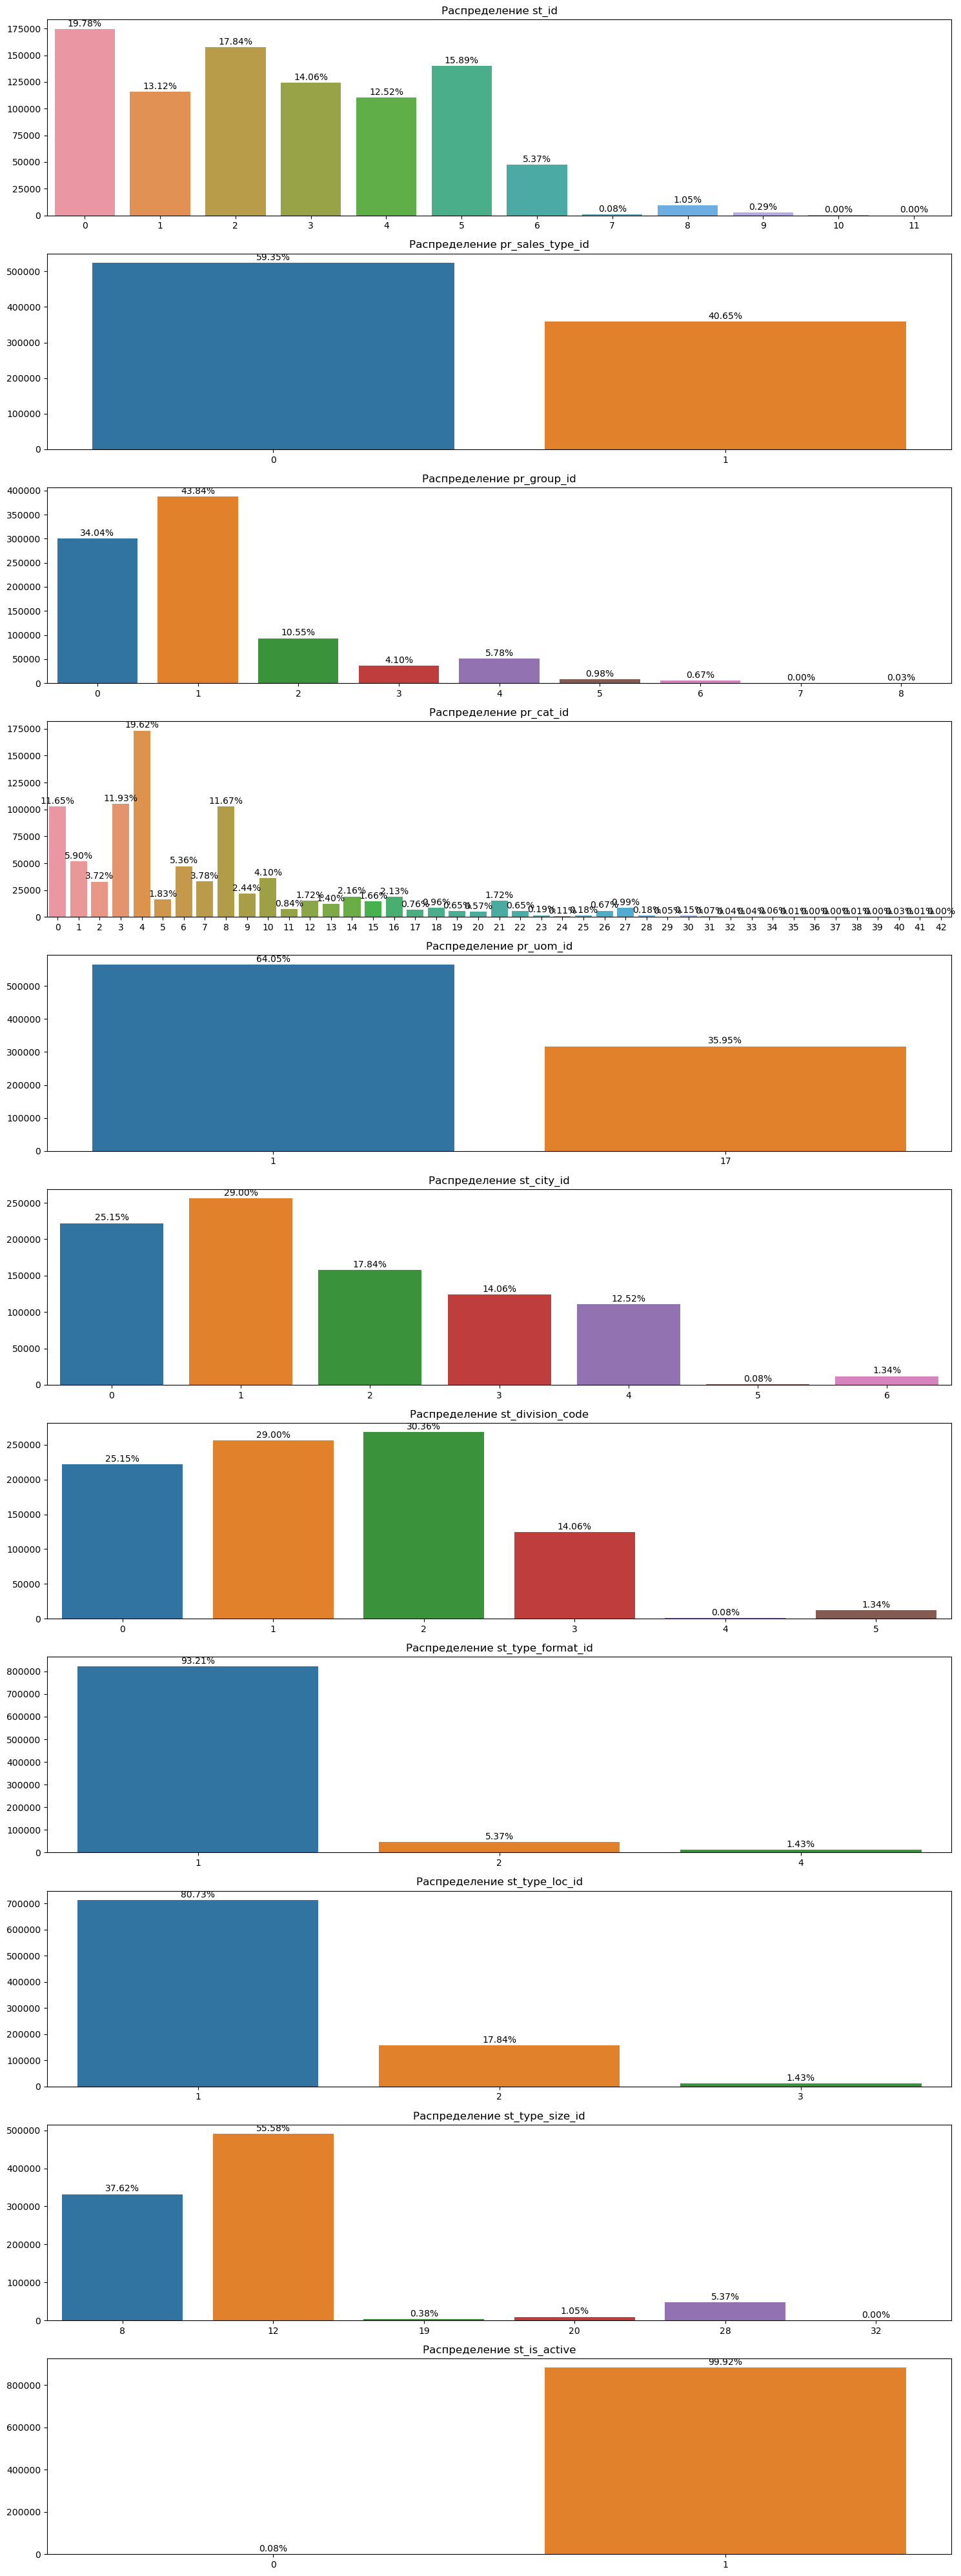

In [15]:
# Построение графиков распределения данных в категориальных признаках
cols = 1
rows = len(cat_cols)
fig = plt.figure(figsize= (15, 40), dpi=100)

for i, col in enumerate(cat_cols):
    ax=fig.add_subplot(rows, cols, i+1)
    sns.countplot(data=df_num , x=col, ax=ax)
    ax.set_title(f"Распределение {col}")
    ax.set(xlabel=None, ylabel=None)
    
    total = len(df_num)
    for p in ax.patches:
        percentage = f'{100 * p.get_height() / total:.2f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='center')
    fig.tight_layout() 
plt.show()

In [16]:
# Создание среза таблицы для просмотра общих продаж в штуках во времени 
df_a = df[['date', 'pr_sales_in_units']]
df_a = set_date_index(df_a, 'date')
df_a = df_a.resample('1d').sum()

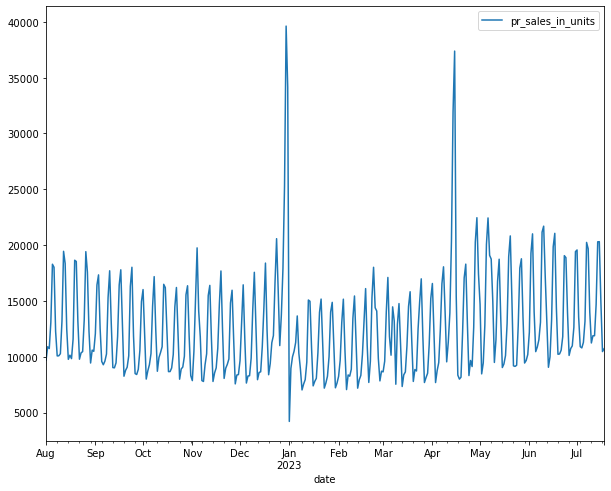

In [17]:
# Вывод графика распределения общих продаж
df_a.plot(figsize=(10, 8))
plt.show()

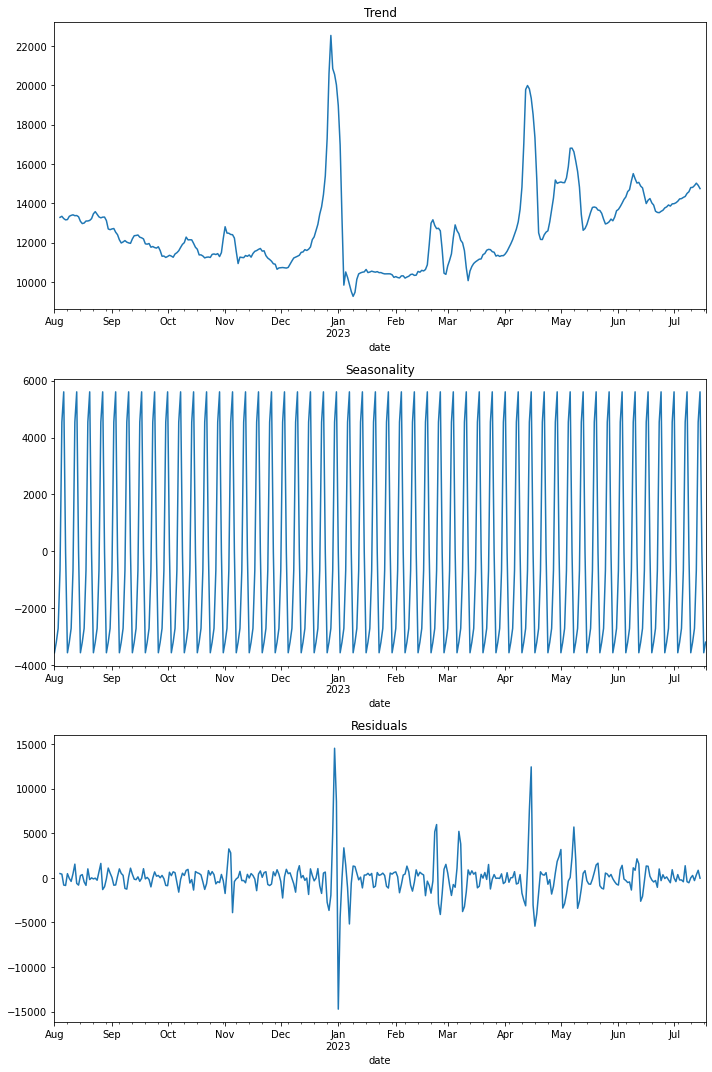

In [18]:
# Визуализация трендов,сезонности общих продаж во времени
decomposed = seasonal_decompose(df_a)

plt.figure(figsize=(10, 15))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

По полученным графикам видно, что в конце декабря имеется очень большой скачок продаж, а потом резкое падение. Такой подьем продаж можно объяснить тем, что происходит празднование Нового года. А вот падение приходится на начало января. Это может быть связано со списанием товаров с ограниченным сроком годности. В целом на графике с трендами видны всплески продаж в период праздников. Например,  в конце февраля - начале марта (23 февраля, 8 марта, масленица) или апрель - май (пасха, 1 мая, 9 мая). Самый низкий тред продаж на графике это январь-февраль, самый высокий декабрь.

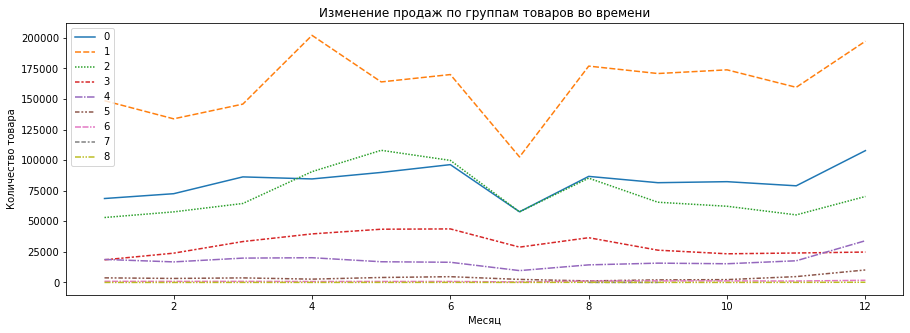

In [19]:
#  Визуализация распределения общих продаж каждой группы товаров во времени
df_plot = df_num[['date', 'pr_group_id', 'pr_sales_in_units']].copy()
df_plot = set_date_index(df_plot, 'date')
pivot_table = df_plot.pivot_table(index=df_plot.index.month, columns='pr_group_id', values='pr_sales_in_units', aggfunc='sum')


plt.figure(figsize=(15, 5))
sns.lineplot(data=pivot_table)

plt.legend(loc='upper left')
plt.xlabel('Месяц')
plt.ylabel('Количество товара')
plt.title('Изменение продаж по группам товаров во времени')

plt.show()

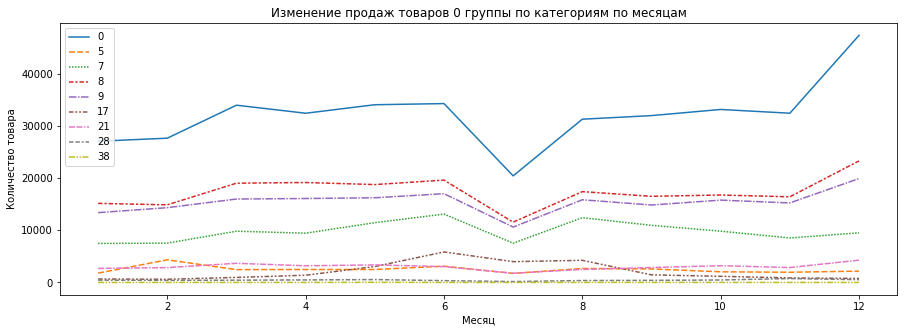

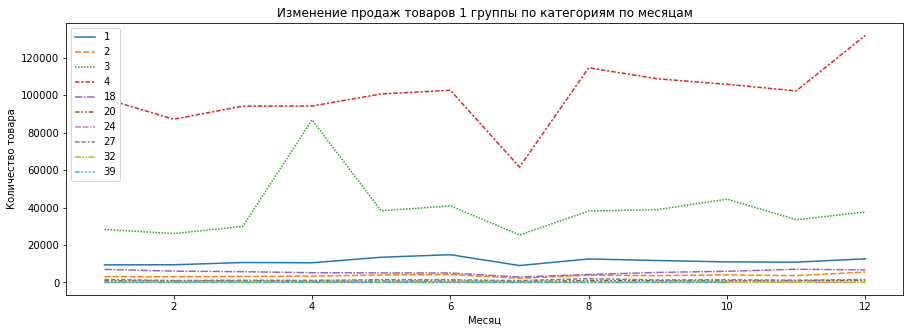

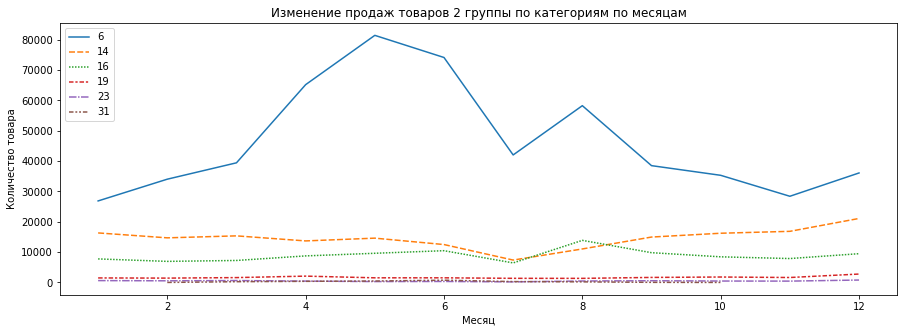

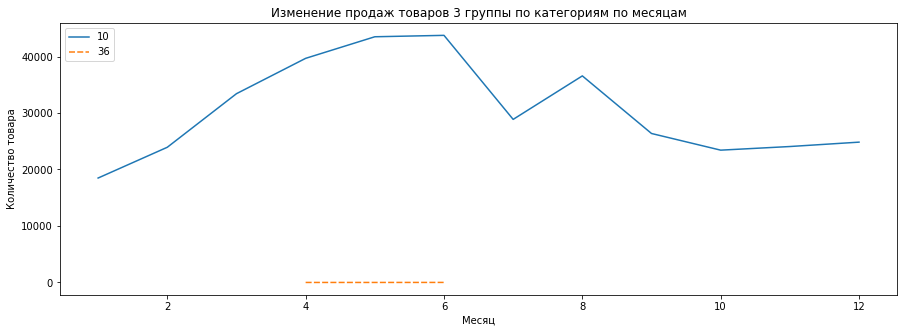

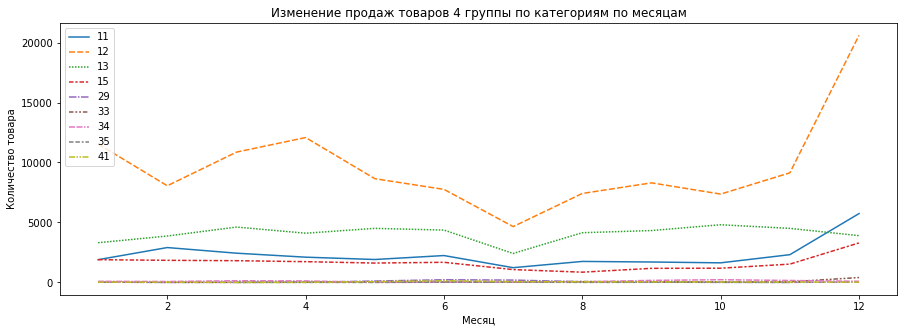

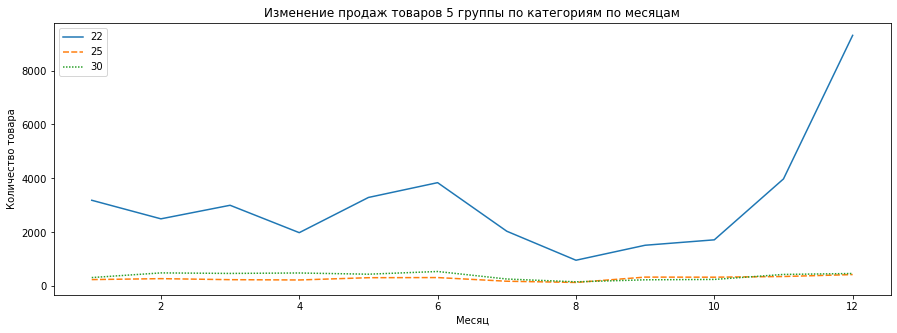

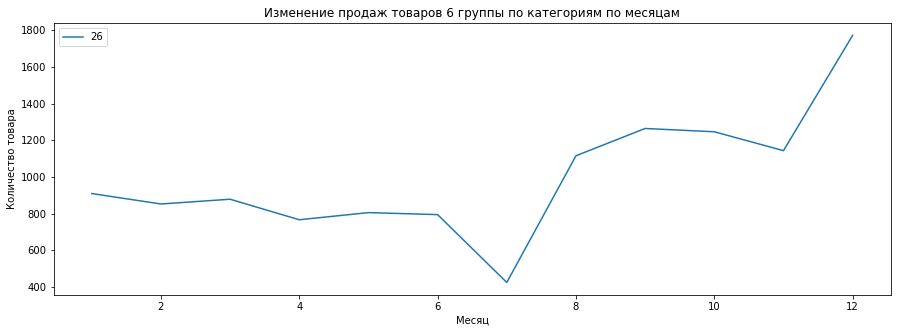

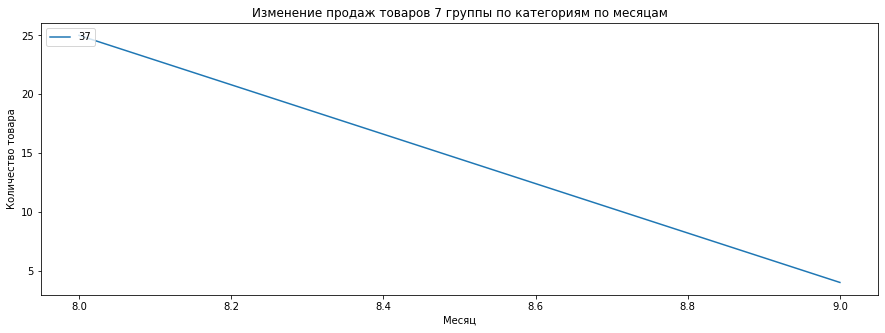

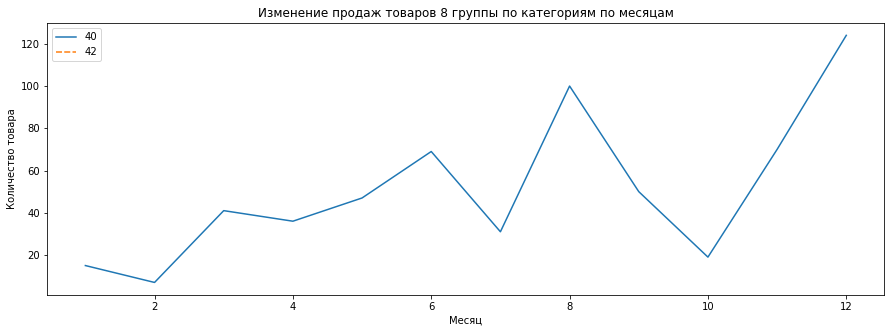

In [20]:
# Визуализация продаж категорий товаров внутри групп во времени
name_group_id = df_num['pr_group_id'].unique()

for name in name_group_id:
    plot_cat_sales(df_num, name,  'date', 'pr_group_id', 'pr_cat_id', 'pr_sales_in_units')
    

In [21]:
del df_plot
del pivot_table
del df_a
del df
del train
del pr
del st_df

In [22]:
df_num = df_num.query('pr_promo_sales_in_units > 0')

# Feature engineering

**Создание дополнительных лаговых и временных признаков**
* pr_sales_in_units_lag - общие продажи за 7 дней в штуках с группировкой по категориям товаров.
* pr_sales_in_rub_lag - общие продажи за 7 дней в рублях с группировкой по категориям товаров..
* pr_sales_in_units_max_lag - максисмальная сумма продаж в штуках за 7 дней с группировкой по категориям товаров.
* pr_sales_in_units_min_lag - минимальная сумма продаж в штуках за 7 дней с группировкой по категориям товаров.
* pr_sales_in_rub_max_lag - максисмальная сумма продаж в рублях за 7 дней с группировкой по категориям товаров.
* pr_sales_in_rub_min_lag - минимальная сумма продаж в рублях за 7 дней с группировкой по категориям товаров.
* mean sales_week_lag - среднее значение продаж за последние 7 дней для каждой группы.
* mean sales_two_week_lag - среднее значение продаж за последние 14 дней для каждой группы.
* lag_feature_diff - разница между средними значениями продаж за последние 7 и 14 дней
* lag_feature_weekday - день недели.
* lag_feature_4weeks - продажи за 4 недели без группировок
* lag_feature_1week - продажи за 1 неделю без группировки.
* sales_ratio - отношения продаж за 4 недели к продажам за последнюю неделю.
* sales_ratio_cat - отношения продаж товара к продажам во всей категории.


In [23]:
df_num = df_num.sort_values('date', ascending=False)

df_num['pr_sales_in_units_lag'] = df_num.groupby('pr_cat_id')['pr_sales_in_units'].shift(7)
df_num['pr_sales_in_rub_lag'] = df_num.groupby('pr_cat_id')['pr_sales_in_rub'].shift(7)

df_num['pr_sales_in_units_max_lag'] = df_num.groupby('pr_cat_id')['pr_sales_in_units'].transform(lambda x: x.rolling(window=7).max())
df_num['pr_sales_in_units_min_lag'] = df_num.groupby('pr_cat_id')['pr_sales_in_units'].transform(lambda x: x.rolling(window=7).min())
df_num['pr_sales_in_rub_max_lag'] = df_num.groupby('pr_cat_id')['pr_sales_in_rub'].transform(lambda x: x.rolling(window=7).max())
df_num['pr_sales_in_rub_min_lag'] = df_num.groupby('pr_cat_id')['pr_sales_in_rub'].transform(lambda x: x.rolling(window=7).min())

# Вычисление среднего значения продаж за последние 7 дней и 14 дней для каждой группы, 
# а также разницы между средними значениями продаж за последние 7 и 14 дне
df_num['mean sales_week_lag'] = df_num.groupby(['pr_cat_id', 'pr_sku_id'])['pr_sales_in_units'].transform(lambda x: x.rolling(window=7).mean())
df_num['mean sales_two_week_lag'] = df_num.groupby(['pr_cat_id', 'pr_sku_id'])['pr_sales_in_units'].transform(lambda x: x.rolling(window=14).mean())
df_num['lag_feature_diff'] = df_num['mean sales_two_week_lag'] - df_num['mean sales_week_lag']

# Создание нового столбца для лагового признака дня недели
df_num['lag_feature_weekday'] = df_num['date'].dt.weekday.shift(1)

# Создание нового столбца для лагового признака продаж за 4 недели
df_num['lag_feature_4weeks'] = df_num['pr_sales_in_units'].rolling(window=28).sum()

# Создание нового столбца для лагового признака продаж за последнюю неделю
df_num['lag_feature_1week'] = df_num['pr_sales_in_units'].rolling(window=7).sum()

# Расчет отношения продаж за 4 недели к продажам за последнюю неделю
df_num['sales_ratio'] = df_num['lag_feature_4weeks'] / df_num['lag_feature_1week']

# Расчет отношения продаж товара к продажам во всей категории
df_num['sales_ratio_cat'] = df_num['pr_sales_in_units'] / df_num.groupby('pr_cat_id')['pr_sales_in_units'].transform('sum')


In [24]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 327643 entries, 540211 to 747714
Data columns (total 32 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   st_id                      327643 non-null  int64         
 1   pr_sku_id                  327643 non-null  int64         
 2   date                       327643 non-null  datetime64[ns]
 3   pr_sales_type_id           327643 non-null  int64         
 4   pr_sales_in_units          327643 non-null  float64       
 5   pr_promo_sales_in_units    327643 non-null  float64       
 6   pr_sales_in_rub            327643 non-null  float64       
 7   pr_promo_sales_in_rub      327643 non-null  float64       
 8   pr_group_id                327643 non-null  int64         
 9   pr_cat_id                  327643 non-null  int64         
 10  pr_subcat_id               327643 non-null  int64         
 11  pr_uom_id                  327643 non-null  int

In [25]:
pd.set_option('display.max_columns', None)
df_num.sample(10)

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active,pr_sales_in_units_lag,pr_sales_in_rub_lag,pr_sales_in_units_max_lag,pr_sales_in_units_min_lag,pr_sales_in_rub_max_lag,pr_sales_in_rub_min_lag,mean sales_week_lag,mean sales_two_week_lag,lag_feature_diff,lag_feature_weekday,lag_feature_4weeks,lag_feature_1week,sales_ratio,sales_ratio_cat
789298,5,461,2022-09-12,1,1.0,1.0,327.0,327.0,1,1,96,1,1,1,1,1,12,1,11.0,651.0,4.0,1.0,569.0,88.0,1.000000,1.071429,0.071429,0.0,92.0,12.0,7.666667,0.000016
854073,6,1802,2023-04-03,1,1.0,1.0,39.0,39.0,1,1,1,17,0,0,2,1,28,1,2.0,367.0,7.0,1.0,452.0,39.0,1.142857,1.500000,0.357143,0.0,135.0,32.0,4.218750,0.000016
557860,3,664,2023-02-23,1,2.0,2.0,185.0,185.0,0,7,13,17,3,3,1,1,12,1,1.0,99.0,3.0,1.0,467.0,92.0,2.285714,2.285714,0.000000,3.0,345.0,51.0,6.764706,0.000059
821558,5,1725,2022-08-18,1,3.0,3.0,494.0,494.0,0,8,16,1,1,1,1,1,12,1,2.0,365.0,14.0,1.0,2861.0,146.0,1.857143,1.642857,-0.214286,3.0,235.0,17.0,13.823529,0.000048
802840,5,562,2023-05-27,1,5.0,5.0,483.0,483.0,5,30,99,1,1,1,1,1,12,1,1.0,109.0,5.0,1.0,483.0,90.0,3.000000,3.857143,0.857143,5.0,233.0,24.0,9.708333,0.001669
549668,3,570,2023-02-20,1,2.0,2.0,518.0,518.0,6,26,83,1,3,3,1,1,12,1,1.0,167.0,5.0,1.0,1093.0,121.0,1.857143,1.500000,-0.357143,0.0,91.0,18.0,5.055556,0.000502
245013,1,308,2022-11-25,1,1.0,1.0,94.0,94.0,4,13,87,1,1,1,1,1,12,1,7.0,912.0,13.0,1.0,1756.0,94.0,11.285714,8.428571,-2.857143,4.0,186.0,85.0,2.188235,0.000029
877085,8,1905,2022-12-20,1,1.0,1.0,26.0,26.0,1,4,8,17,6,5,4,3,20,1,5.0,40.0,4.0,1.0,217.0,26.0,2.428571,2.142857,-0.285714,1.0,65.0,13.0,5.000000,0.000003
843492,6,273,2023-01-16,1,4.0,4.0,81.0,81.0,1,4,11,17,0,0,2,1,28,1,9.0,78.0,4.0,1.0,96.0,15.0,4.714286,4.857143,0.142857,0.0,66.0,25.0,2.640000,0.000013
459200,3,43,2022-11-17,1,7.0,7.0,89.0,89.0,1,4,8,17,3,3,1,1,12,1,6.0,251.0,7.0,1.0,362.0,23.0,9.428571,9.214286,-0.214286,3.0,93.0,16.0,5.812500,0.000023
